<a href="https://colab.research.google.com/github/EgeSarii/Reinforcement-Learning/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning 5: *Temporal Difference Learning*

**Assignment:** hand-in before 14/03/2022.



#### 1. Q-Learning vs SARSA

In this week's assignment, you will implement Q-learning (off-policy TD control) and SARSA (on-policy TD control) to find optimal $\epsilon$-greedy policies to solve 2 example tasks:
- `WindyGridworld` (example 6.5 in the textbook)
- `CliffWalking` (example 6.6 in the textbook)

**References:**
[1] - Sutton & Barto, Chapter 6 (examples 6.5 and 6.6)

Let's start by creating custom environments.

- `WindyGridworld`:
![](https://drive.google.com/uc?id=1uZO6aMctS3S0kicTQjSyaGvpFX5oBpkb)

In [1]:
from collections import defaultdict, namedtuple
from io import StringIO

import gym
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import sys
from gym.envs.toy_text import discrete

# define a data structure to store the relevant statistics of an episode
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

In [2]:
class WindyGridworldEnv(discrete.DiscreteEnv):
    metadata = {'render.modes': ['human']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
        self.shape = (7, 10)
        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0
        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = sys.stdout
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "
            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"
            outfile.write(output)
        outfile.write("\n")

- `CliffWalking`:
![](https://drive.google.com/uc?id=1tHK_CgIpbHecZRgOUGH2w3LxqWYLTGBI)

In [3]:
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3

class CliffWalkingEnv(discrete.DiscreteEnv):
    metadata = {'render.modes': ['human']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3, 11))
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=bool)
        self._cliff[3, 1:-1] = True

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(nA)}
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3, 0), self.shape)] = 1.0

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self):
        outfile = sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            elif position == (3, 11):
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"
            outfile.write(output)
        outfile.write("\n")

**a.1)** Explore the `WindyGridworld` environment you just created, run and render 10 steps with a uniform random policy.

*(0.5 points)*

In [25]:
env1 = WindyGridworldEnv()
env1.render(mode= 'human')

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [27]:
for i in range(10):
    action_probs = [0.25, 0.25, 0.25, 0.25]
    action =np.random.choice(np.arange(len(action_probs)), p=action_probs)
    env1.step(action)
    env1.render(mode ='human')

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

**a.2)** Explore the `CliffWalking` environment you just created, run and render 10 steps with a uniform random policy.

*(0.5 points)*

In [19]:
env2 = CliffWalkingEnv()
env2.render()
#

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [28]:
for i in range(10):
    action_probs = [0.25, 0.25, 0.25, 0.25]
    action =np.random.choice(np.arange(len(action_probs)), p=action_probs)
    env1.step(action)
    env1.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

**b**) Write a function that creates an $\epsilon$-greedy policy for a given Q-value function and $\epsilon$.

*(2 points)*

In [79]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] = (epsilon/ nA) +1 -epsilon
        return A
    return policy_fn

**c**) Write a function that implements the Q-learning algorithm (off-policy TD control) to find the optimal $\epsilon$-greedy policy.

*(3 points)*

In [90]:
from numpy.random.mtrand import gamma
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Reset the environment and pick the first action
        state = env.reset()

        # One step in the environment
        for t in itertools.count():

            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # TD Update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + (discount_factor * Q[next_state][best_next_action])
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                break

            state = next_state

    return Q, stats

**d**) Write a function that implements the SARSA algorithm (on-policy TD control) to find the optimal $\epsilon$-greedy policy.

*(3 points)*

In [91]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)

            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # TD Update
            td_target = reward + (discount_factor * Q[next_state] [next_action])
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if done:
                break

            action = next_action
            state = next_state

    return Q, stats

**e**) Run SARSA and Q-learning on both environments, plot and compare the results.

*(1 point)*

In [92]:
# let's first define some visualization functions
def plot_episode_lengths(ax, episode_lengths, label=''):
    ax.plot(episode_lengths, label=label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Episode Length")
    ax.set_title("Episode Length over Time")

def plot_reward(ax, episode_rewards, smoothing_window=10, label=''):
    rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    ax.plot(rewards_smoothed, label=label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Episode Reward (Smoothed)")
    ax.set_title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))

def plot_episode_per_timestep(ax, episode_lengths, label=''):
    # Plot time steps and episode number
    ax.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)), label=label)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Episode")
    ax.set_title("Episode per time step")

In [93]:
# Environment 1
Q_sarsa1, sarsa_stats1 = sarsa(env1, 200)
Q_td1, Q_stats1 = q_learning(env1, 200)

Episode 200/200.

In [94]:
# Environment 2
Q_sarsa2, sarsa_stats2 = sarsa(env2, 200)
Q_td2, Q_stats2 = q_learning(env2, 200)

Episode 200/200.

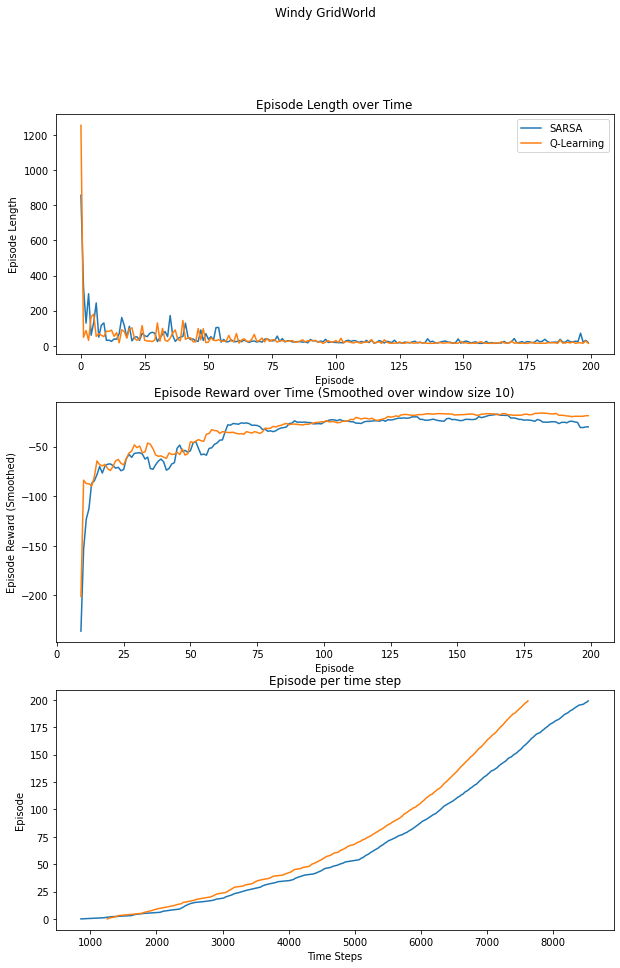

In [95]:
# Plot results for the Windy GridWorld environment
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Windy GridWorld")
plot_episode_lengths(ax[0], sarsa_stats1.episode_lengths, label='SARSA')
plot_episode_lengths(ax[0], Q_stats1.episode_lengths, label='Q-Learning')

plot_reward(ax[1], sarsa_stats1.episode_rewards, smoothing_window=10, label='SARSA')
plot_reward(ax[1], Q_stats1.episode_rewards, smoothing_window=10, label='Q-Learning')

plot_episode_per_timestep(ax[2], sarsa_stats1.episode_lengths, label='SARSA')
plot_episode_per_timestep(ax[2], Q_stats1.episode_lengths, label='Q-Learning')

ax[0].legend()

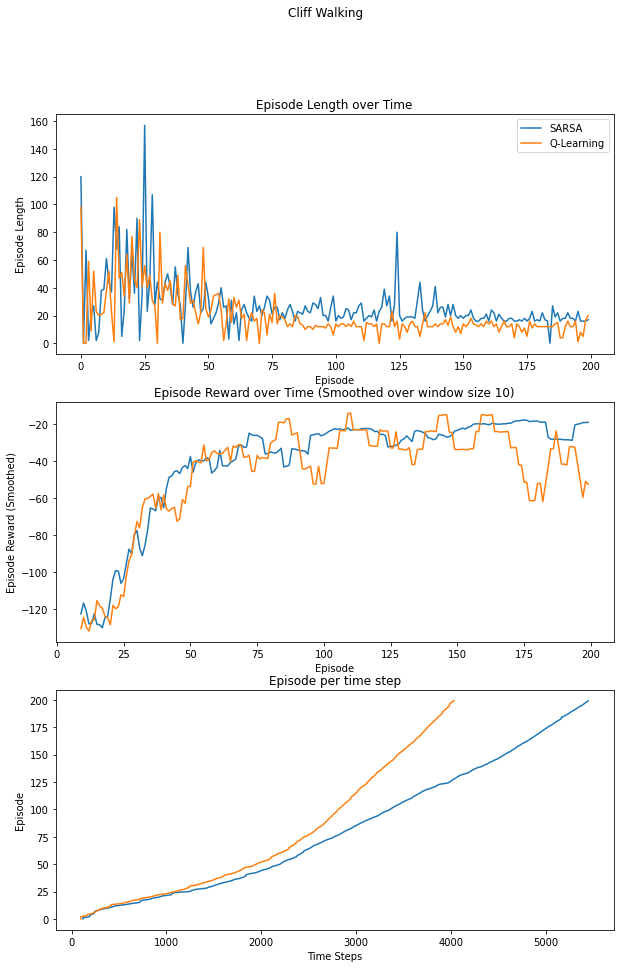

In [96]:
# Plot results for the Cliff Walking environment
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle("Cliff Walking")
plot_episode_lengths(ax[0], sarsa_stats2.episode_lengths, label='SARSA')
plot_episode_lengths(ax[0], Q_stats2.episode_lengths, label='Q-Learning')

plot_reward(ax[1], sarsa_stats2.episode_rewards, smoothing_window=10, label='SARSA')
plot_reward(ax[1], Q_stats2.episode_rewards, smoothing_window=10, label='Q-Learning')

plot_episode_per_timestep(ax[2], sarsa_stats2.episode_lengths, label='SARSA')
plot_episode_per_timestep(ax[2], Q_stats2.episode_lengths, label='Q-Learning')
ax[0].legend()